# Spatio-temporal Analysis of Precipitation Trends in Nepal (1995–2024) Using CHIRPS Satellite-Based Rainfall Data at 0.05° (~5 km) Spatial Resolution

[1. CHIRPS Data Preprocessing](#chirps-data-preprocessing)

[2. Precipitation Data Analysis](#precipitation-data-analysis)

## 1. CHIRPS Data Preprocessing

This section explains how I prepared CHIRPS rainfall data (NetCDF format) for analysis by masking it to Nepal's boundary, handling missing values, and ensuring spatial compatibility between datasets.

In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray as rio
from shapely.geometry import mapping
from mpl_toolkits.axes_grid1 import make_axes_locatable
import  pymannkendall as mk
import seaborn as sns

In [2]:
#Loading Rainfall data and Nepal shapefile
xr_dataset= xr.open_dataset('Dataset/Nepal_masked_cleaned_chirps_1995_2024.nc')
shape_file= gpd.read_file('Shapefile/Nepal_bnd_WGS84.shp')

In [3]:
#Removing Existing Missing Value Attributes
xr_dataset.attrs.pop('_FillValue',None)
xr_dataset.attrs.pop('missing_value', None)

In [4]:
#Encoding Missing Values with -99.9
encoding={'tp':{'_FillValue':-99.9,
            'missing_value':-99.9}
        }
xr_dataset.to_netcdf('Dataset/xr_dataset_encoded_missingvalues.nc', encoding=encoding)

In [5]:
#Reloading Dataset and Mask Missing Values
xr_dataset_encoded= xr.open_dataset('Dataset/xr_dataset_encoded_missingvalues.nc')
dataset=xr_dataset_encoded.where(xr_dataset_encoded.tp != -99.9)

In [6]:
#Projecting Both Raster and Shapefile to Same CRS
dataset =dataset.rio.write_crs('EPSG:4326')
gdf=shape_file.to_crs(dataset.rio.crs)

## 2.  Precipitation Data Analysis

This section presents a detailed analysis of precipitation over Nepal from 1995 to 2024, using CHIRPS satellite-based rainfall estimates. The analysis explores both temporal trends and spatial patterns to understand seasonal variability, long-term changes, and the regional distribution of rainfall. In addition to these analyses, precipitation extremes were assessed using five standard climatic indices to evaluate the frequency and intensity of extreme rainfall events across Nepal. The Mann-Kendall test was applied to detect statistically significant trends in both the climatic normals and the precipitation indices.



### 2.1 Climatic Normal
This sub-section presents the **spatial and temporal climatic normals** of precipitation in Nepal.

Both  **seasonal** and **annual** normals were calculated by averaging the time-series precipitation data over the period **1995 to 2024**. 

- **Seasonal Normal**: Computed by averaging precipitation for each defined season (Winter, Pre-Monsoon, Monsoon, and Post-Monsoon) across time.
- **Annual Normal**: Calculated by averaging precipitation data for each year across the full 30-year period.

This analysis helps visualize Nepal's long-term precipitation behavior.


#### 2.1.1 Seasonal Precipitation Analysis (1995–2024): Temporal Trends and Spatial Distribution

Nepal experiences four distinct seasons based on rainfall and temperature patterns:

- **Winter**: December, January, and February   
- **Pre-Monsoon**: March to May  
- **Monsoon**: June to September  
- **Post-Monsoon**: October and November

Here, I have calculated and visualized **the seasonal average precipitation (in millimeters)** for each year from 1995 to 2024. I also applied the Mann-Kendall trend test to identify statistically significant trends in seasonal precipitation over time. Additionally, I computed and visualized the long-term spatial average precipitation for each season during the same period to analyze the spatial distribution of rainfall across Nepal.


In [7]:
# Resampling our daily data into monthly sum\
monthly_sum=dataset.resample(time='1ME').sum(dim=['time'], skipna=True)
monthly_sum

yearly_sum=dataset.resample(time='YE').sum(dim=['time'], skipna=True)
yearly_sum

dataset_area_mean = dataset.mean(dim=['lat', 'lon'])
dataset_area_mean = dataset_area_mean.to_dataframe().reset_index()
dataset_area_mean['year'] = dataset_area_mean['time'].dt.year
dataset_area_mean['month'] = dataset_area_mean['time'].dt.month


In [8]:
#Defing Nepal's season
seasons ={'Winter':[12,1,2],
          'Pre-Monsoon':[3,4,5],
          'Monsoon':[6,7,8,9],
          'Post-Monsoon':[10,11]
         }
seasons.items()

dict_items([('Winter', [12, 1, 2]), ('Pre-Monsoon', [3, 4, 5]), ('Monsoon', [6, 7, 8, 9]), ('Post-Monsoon', [10, 11])])

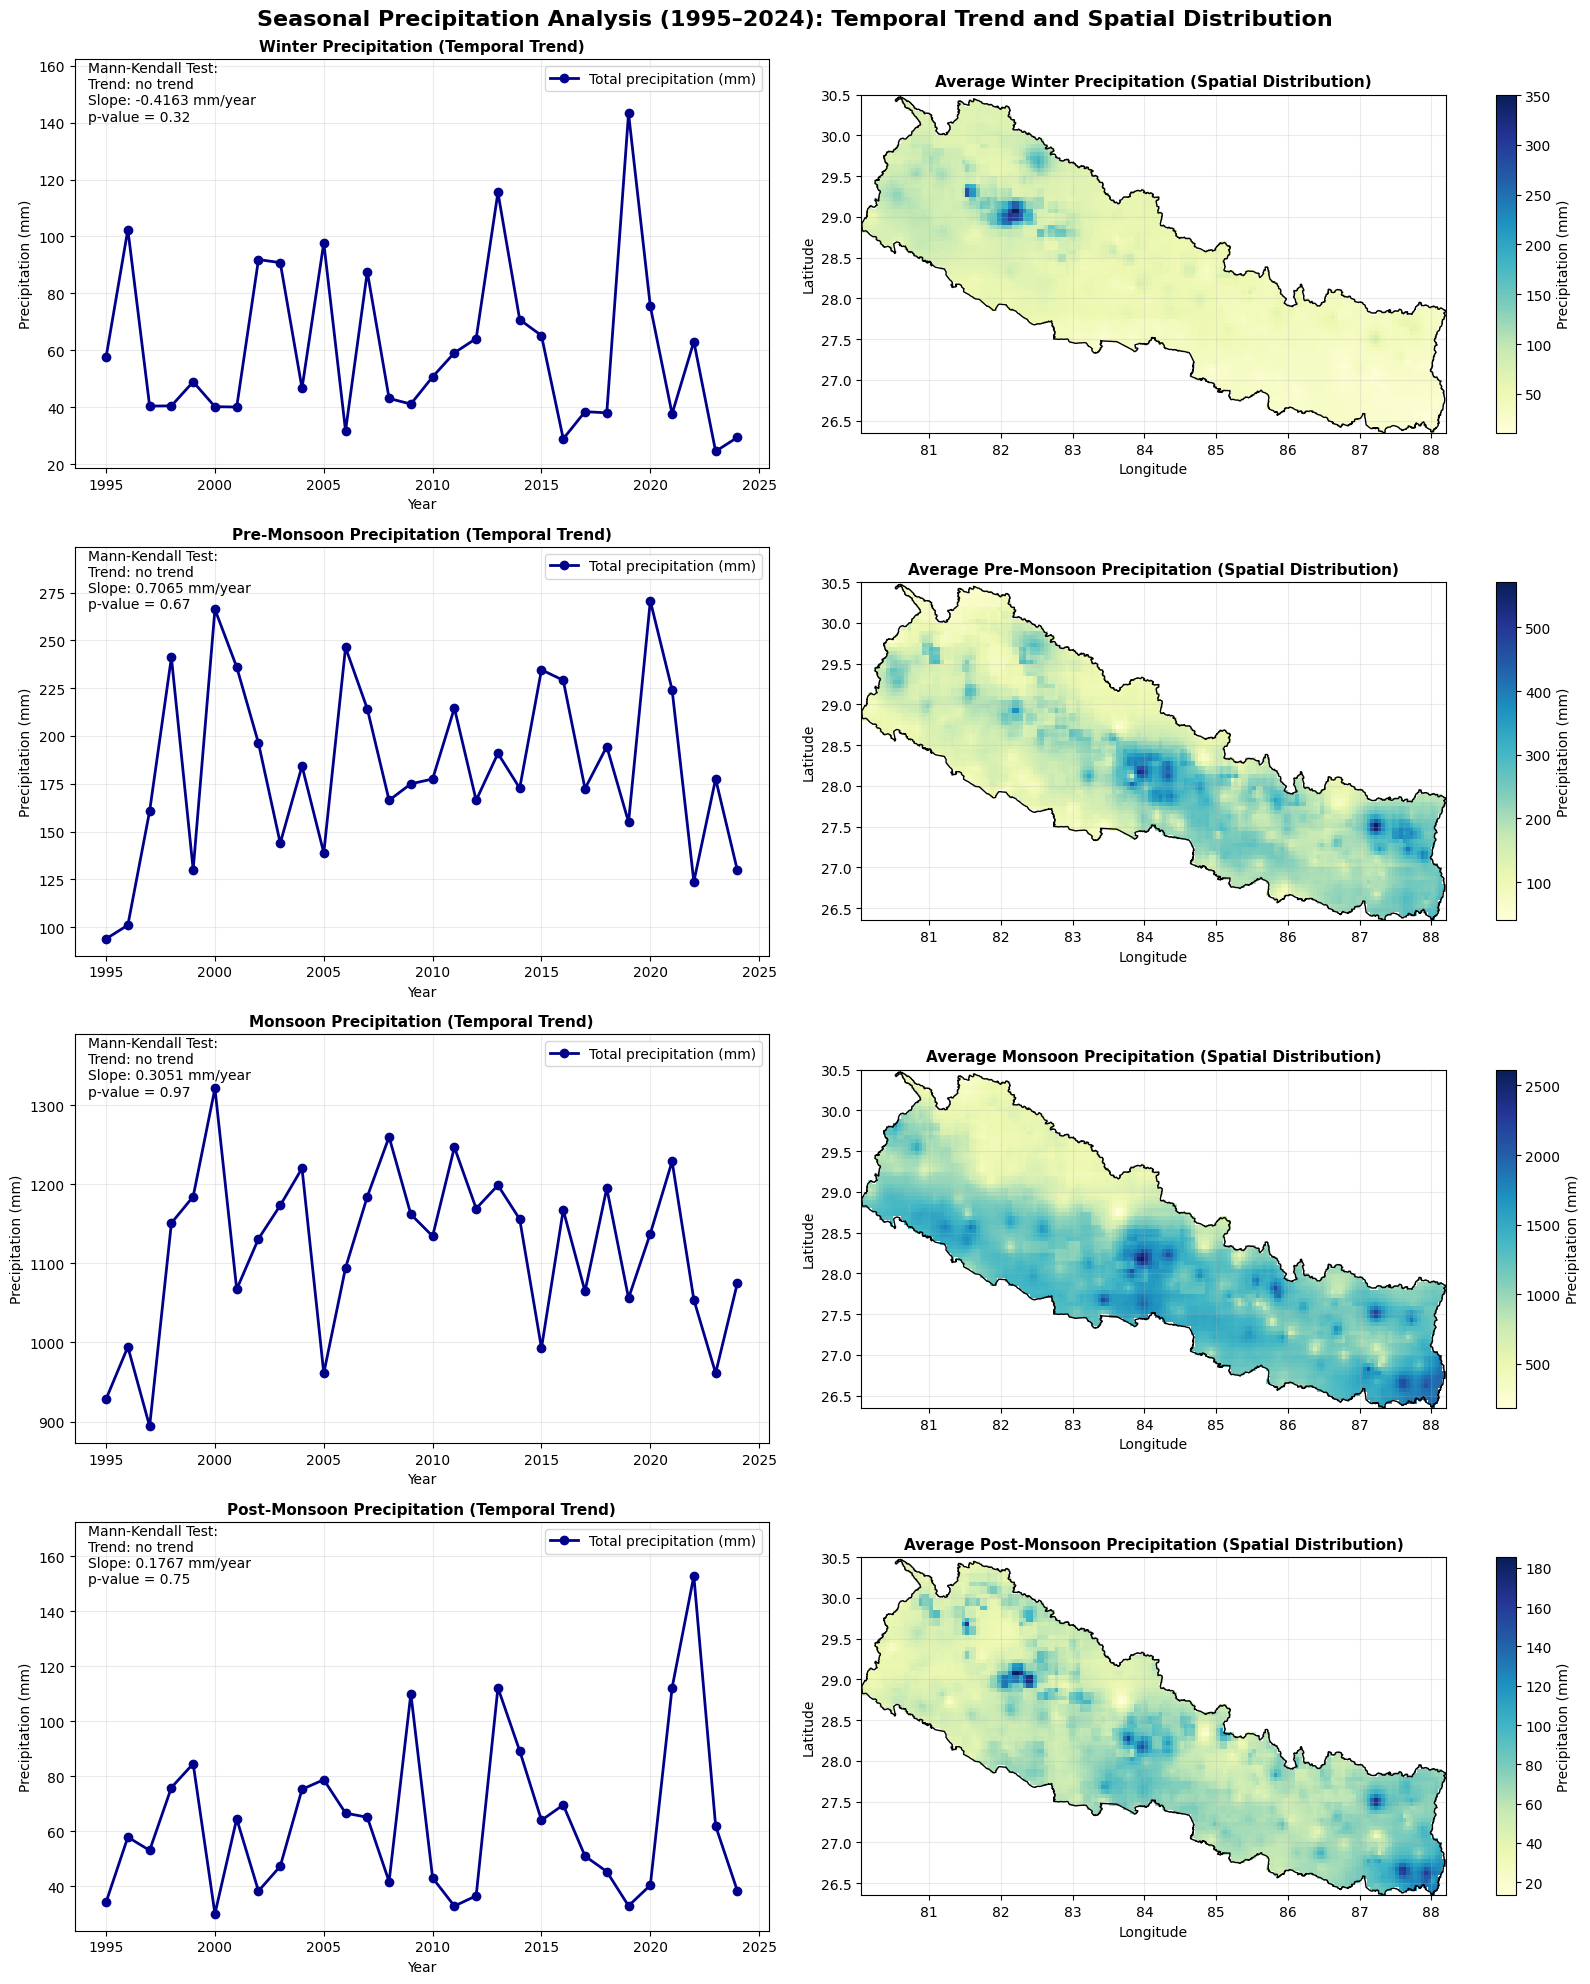

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(16, 20))
ax = ax.flatten()

for i, (name, months) in enumerate(seasons.items()):
    # Temporal trend analysis on the left column (ax[2*i])
    seasonal_data = dataset_area_mean[dataset_area_mean['month'].isin(months)]
    seasonal_grouped = seasonal_data.groupby('year')['tp'].sum()
    values = seasonal_grouped.values
    mk_result = mk.original_test(values)
    slope = mk_result.slope
    p_value = mk_result.p

    seasonal_grouped.plot(ax=ax[2*i], marker='o', color='darkblue', linewidth=2, label='Total precipitation (mm)')
    ax[2*i].set_title(f'{name} Precipitation (Temporal Trend)', fontsize=11, fontweight='bold')
    ax[2*i].set_xlabel('Year')
    ax[2*i].set_ylabel('Precipitation (mm)')
    trend_text = f"Mann-Kendall Test:\nTrend: {mk_result.trend}\nSlope: {slope:.4f} mm/year\np-value = {p_value:.2f}"
    ax[2*i].text(0.02, 0.85, trend_text, transform=ax[2*i].transAxes, fontsize=10)
    ymin, ymax = ax[2*i].get_ylim()
    ax[2*i].set_ylim(ymin, ymax + 0.1 * (ymax - ymin))
    ax[2*i].legend()
    ax[2*i].grid(True, alpha=0.25)

    # Spatial average & map plot on the right column (ax[2*i+1])
    data = monthly_sum.sel(time=monthly_sum['time.month'].isin(months))
    yearly_sum_season = data.resample(time='YE').sum(dim='time', skipna=True)
    average = yearly_sum_season['tp'].mean(dim='time')
    average_clip = average.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=False)

    img = average_clip.plot(cmap='YlGnBu', ax=ax[2*i+1], add_colorbar=False)
    divider = make_axes_locatable(ax[2*i+1])
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Precipitation (mm)', fontsize=10)

    ax[2*i+1].set_title(f'Average {name} Precipitation (Spatial Distribution)', fontsize=11, fontweight='bold')
    ax[2*i+1].set_xlabel('Longitude')
    ax[2*i+1].set_ylabel('Latitude')
    ax[2*i+1].grid(True, alpha=0.25)
    gdf.boundary.plot(ax=ax[2*i+1], edgecolor='black', linewidth=1)

plt.suptitle('Seasonal Precipitation Analysis (1995–2024): Temporal Trend and Spatial Distribution', fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()


plt.savefig("Charts/seasonal_precip_trend.png", dpi=300)
plt.show()
plt.close()

#### 2.1.2  Annual Precipitation Analysis (1995–2024): Temporal Trend and Spatial Distribution
Here, I calculated and visualized the **the annual average precipitation (in millimeters)**  from 1995 to 2024. I also applied the Mann-Kendall trend test to identify statistically significant trends in annual precipitation over time. Additionally, I computed and visualized the long-term spatial annual average precipitation during the same period.

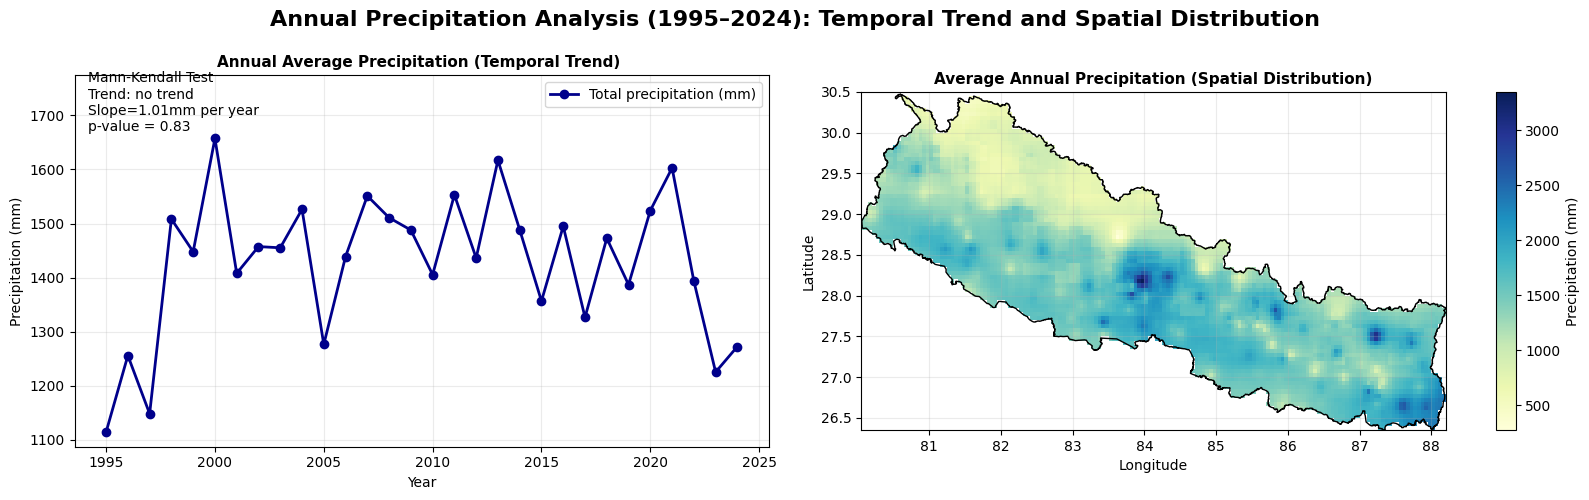

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Temporal Trend
yearly_df = dataset_area_mean.groupby('year')['tp'].sum().reset_index()
yearly_df.plot(x='year', y='tp', ax=ax[0], marker='o', color='darkblue', linewidth=2, label='Total precipitation (mm)')

# Mann-Kendall Test
values = yearly_df['tp'].values
mk_result = mk.original_test(values)
slope = mk_result.slope
p_value = mk_result.p

ax[0].set_title('Annual Average Precipitation (Temporal Trend) ', fontsize=11, fontweight='bold')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Precipitation (mm)')
ymin, ymax= ax[0].get_ylim()
ax[0].set_ylim(ymin,ymax+0.15 * (ymax-ymin))
trend_text = f"Mann-Kendall Test\nTrend: {mk_result.trend}\nSlope={slope:.2f}mm per year\np-value = {p_value:.2f}"
ax[0].text(0.02, 0.85, trend_text, transform=ax[0].transAxes, fontsize=10)
ax[0].legend()
ax[0].grid(True, alpha=0.25)

# Spatial Distribution
yearly_sum_area = yearly_sum.mean(dim='time') 
average_clip = yearly_sum_area.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=False)
img = average_clip['tp'].plot(ax=ax[1], cmap='YlGnBu', add_colorbar=False)
gdf.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.1)
cbar = plt.colorbar(img, cax=cax)
cbar.set_label('Precipitation (mm)', fontsize=10)

ax[1].set_title('Average Annual Precipitation (Spatial Distribution)', fontsize=11, fontweight='bold')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].grid(True, alpha=0.25)

plt.suptitle('Annual Precipitation Analysis (1995–2024): Temporal Trend and Spatial Distribution', fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()


plt.savefig("Charts/annual_precip_trend.png", dpi=300)
plt.show()
plt.close()

### 2.2 Climatic Indices
In this sub-section, I analyzed precipitation extremes in Nepal using five standard precipitation indices developed jointly by the Expert Team on Climate Change Detection and Indices (ETCCDI), the World Meteorological Organization (WMO) Commission for Climatology, and the Climate Variability and Predictability (CLIVAR) project.

**Precipitation Extremes Indices Analyzed:**
- **R1mm (Number of Wet Days):**  
  Annual count of days when daily precipitation is **≥ 1 mm**.

- **R10mm (Number of Heavy Precipitation Days):**  
  Annual count of days when daily precipitation is **≥ 10 mm**.

- **R20mm (Number of Very Heavy Precipitation Days):**  
  Annual count of days when daily precipitation is **≥ 20 mm**.

- **R95p (Very Wet Days):**  
  Total precipitation (mm) on days when precipitation exceeds the **95th percentile**.

- **R99p (Extremely Wet Days):**  
  Total precipitation (mm) on days when precipitation exceeds the **99th percentile**.


#### 2.2.1 Temporal and Spatial Trends in Moderate to Extreme Precipitation Thresholds (PRCP ≥ 1, 10, 20 mm)
This analysis investigates the temporal and spatial trends of precipitation extremes over Nepal during the period 1995–2024 using a threshold-based approach. Specifically, the study evaluates the annual number of days when daily precipitation exceeds 1 mm, 10 mm, and 20 mm, respectively. 

**Temporal Analysis:**
For each threshold, the annual count of exceedance days was aggregated across the study area. A Mann–Kendall (MK) trend test was applied to detect monotonic trends and assess their statistical significance. 

**Spatial Analysis:**
The spatial trend in the number of exceedance days per year was computed at each grid cell using the MK test. Only statistically significant trends (p < 0.05) were retained for visualization, revealing localized patterns of increasing or decreasing extremes. The resulting spatial maps display the slope of the trend, providing insight into where precipitation extremes are becoming more frequent or less common.

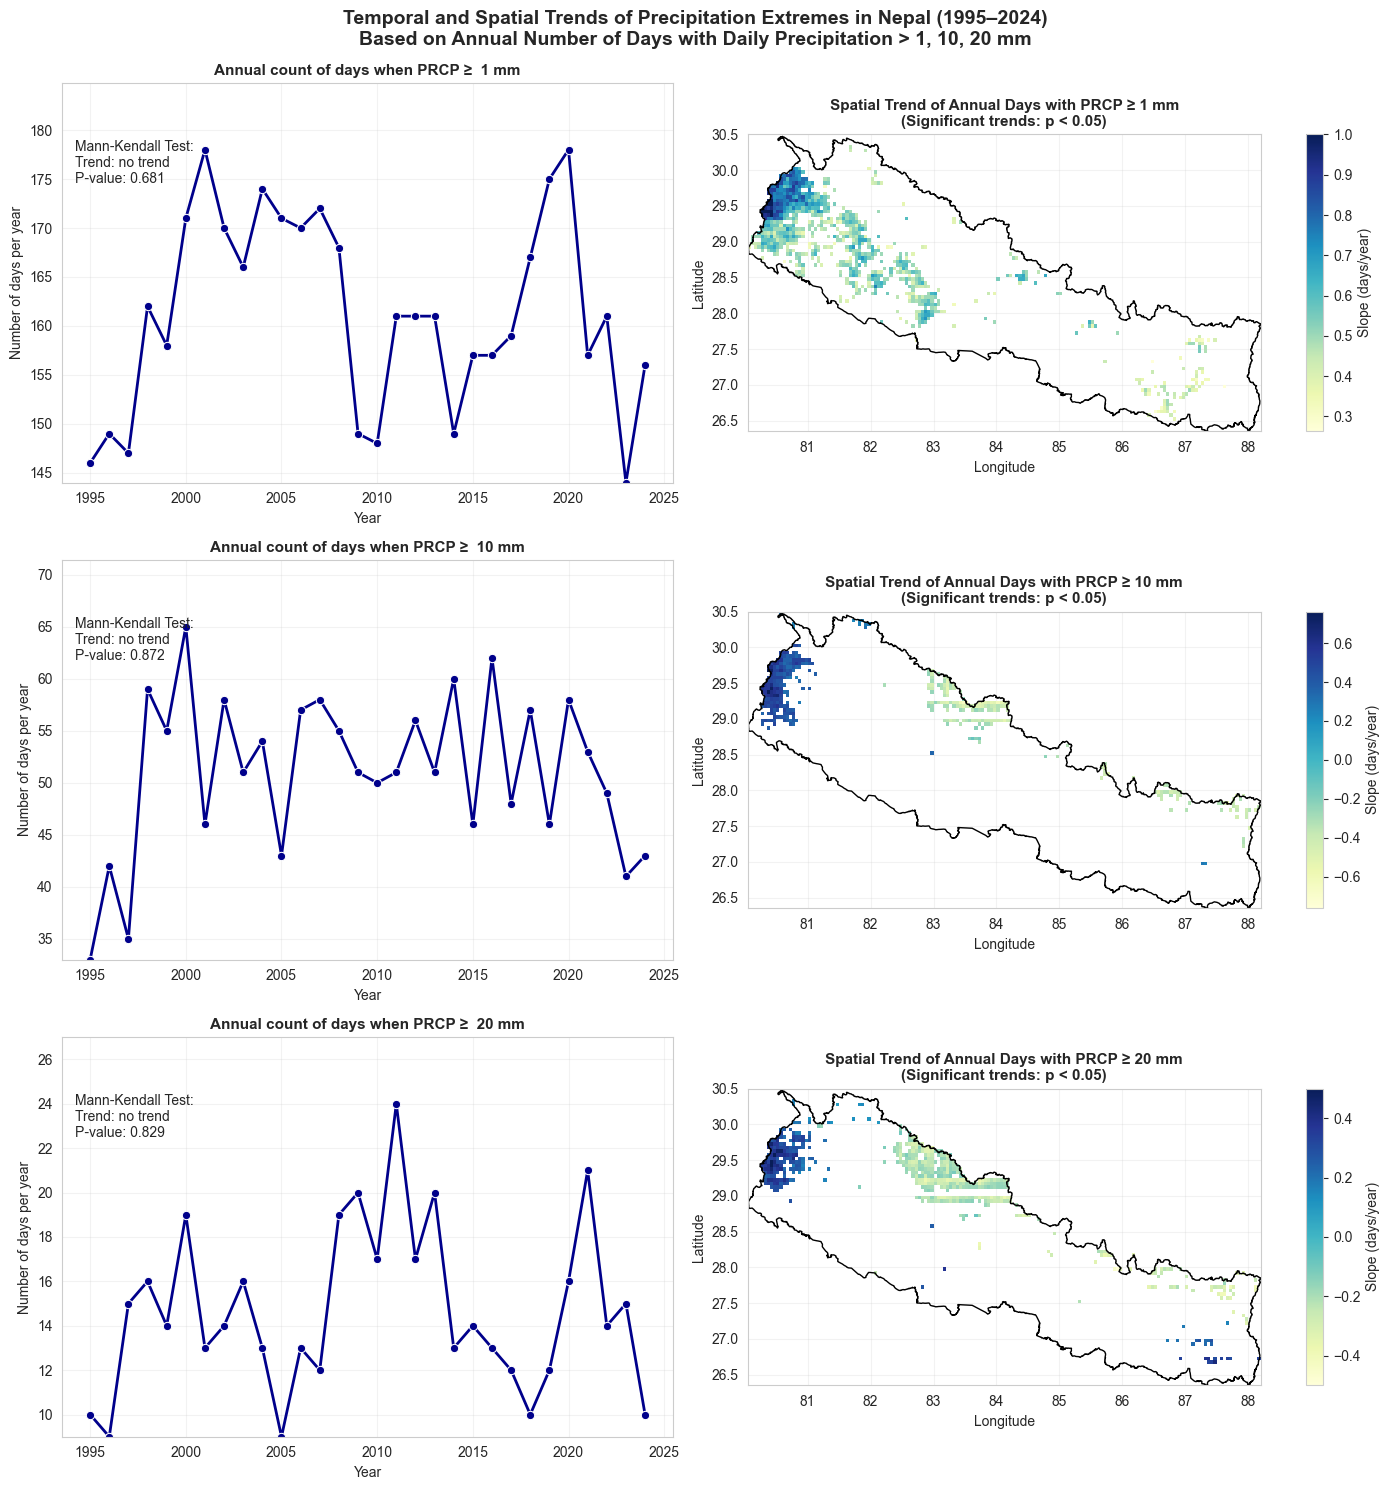

In [11]:

Rmm = [1, 10, 20]
sns.set_style('whitegrid')
fig, ax = plt.subplots(3, 2, figsize=(14, 15))
ax = ax.flatten()

for i, rmm in enumerate(Rmm):
    # --- Temporal Trend ---
    df = dataset_area_mean[dataset_area_mean['tp'] >= rmm]
    df_yearlysum = df.groupby('year')['tp'].count().reset_index()
    sns.lineplot(data=df_yearlysum, x='year', y='tp', ax=ax[2 * i], marker='o', linewidth=2, color='darkblue')
    
    ax[2 * i].set_title(f"Annual count of days when PRCP ≥  {rmm} mm", fontsize=11, fontweight='bold')
    ax[2 * i].set_ylabel("Number of days per year")
    ax[2 * i].set_xlabel("Year")
    ax[2 * i].grid(True, alpha=0.25)

    values = df_yearlysum['tp']
    mk_result = mk.original_test(values)
    slope = mk_result.slope
    p_value = mk_result.p
    trend = mk_result.trend

    # Annotating Mann-Kendall results
    text = f"Mann-Kendall Test:\nTrend: {trend}\nP-value: {p_value:.3f}"
    if p_value < 0.05:
        text += "\n*Significant at 95% level"
    ax[2 * i].text(0.02, 0.75, text, transform=ax[2 * i].transAxes, fontsize=10)

    ymin = df_yearlysum['tp'].min()
    ymax = df_yearlysum['tp'].max()
    ax[2*i].set_ylim(ymin, ymax + 0.2 * (ymax - ymin))

    # --- Spatial Trend Visualization ---
    data_rmm = dataset['tp'] > rmm
    greater_than_mm = data_rmm.resample(time='YE').sum(dim='time', skipna=True)

    lat = greater_than_mm['lat']
    lon = greater_than_mm['lon']
    slope_array = np.full((len(lat), len(lon)), np.nan)
    p_array = np.full((len(lat), len(lon)), np.nan)

    for j in range(len(lat)):
        for k in range(len(lon)):
            gr = greater_than_mm[:, j, k].values
            if np.isnan(gr).all() or np.all(gr == 0):
                continue
            result = mk.original_test(gr)
            slope_array[j, k] = result.slope
            p_array[j, k] = result.p

    slope_da = xr.DataArray(slope_array, coords=[lat, lon], dims=['lat', 'lon'])
    p_da = xr.DataArray(p_array, coords=[lat, lon], dims=['lat', 'lon'])
    masked_slope_da = slope_da.where(p_da < 0.05)

    img = masked_slope_da.plot(cmap='YlGnBu', ax=ax[2 * i + 1], add_colorbar=False)
    divider = make_axes_locatable(ax[2 * i + 1])
    cax = divider.append_axes('right', size='3%', pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Slope (days/year)')

    ax[2 * i + 1].set_title(f"Spatial Trend of Annual Days with PRCP ≥ {rmm} mm\n(Significant trends: p < 0.05)", fontsize=11, fontweight='bold')
    ax[2 * i + 1].set_xlabel('Longitude')
    ax[2 * i + 1].set_ylabel('Latitude')
    ax[2 * i + 1].grid(True, alpha=0.25)

    gdf.boundary.plot(ax=ax[2 * i + 1], edgecolor='black', linewidth=1)


plt.suptitle(
    "Temporal and Spatial Trends of Precipitation Extremes in Nepal (1995–2024)\n"
    "Based on Annual Number of Days with Daily Precipitation > 1, 10, 20 mm", fontsize=14, fontweight='bold',
    y=0.99
)

plt.tight_layout()
plt.savefig("Charts/Rmm_precip_trend.png", dpi=300)
plt.show()
plt.close()

#### 2.2.2 Temporal and Spatial Trends in Annual Total Precipitation on Extreme Wet Days (R95p and R99p) 
This analysis quantifies changes in annual total precipitation associated with extreme wet days, defined using the 95th and 99th percentiles (R95p and R99p) of wet-day precipitation during a 1995–2015 reference period. Wet days are defined as days with precipitation ≥1 mm. Thresholds are derived from the reference period, and extreme events are identified in the full dataset accordingly.

The total precipitation on extreme wet days is computed annually and spatially for each grid cell, and Mann-Kendall trend analysis is applied to identify statistically significant changes. Only statistically significant trends (p < 0.05) were retained for visualization, revealing localized patterns of increasing or decreasing extremes. 

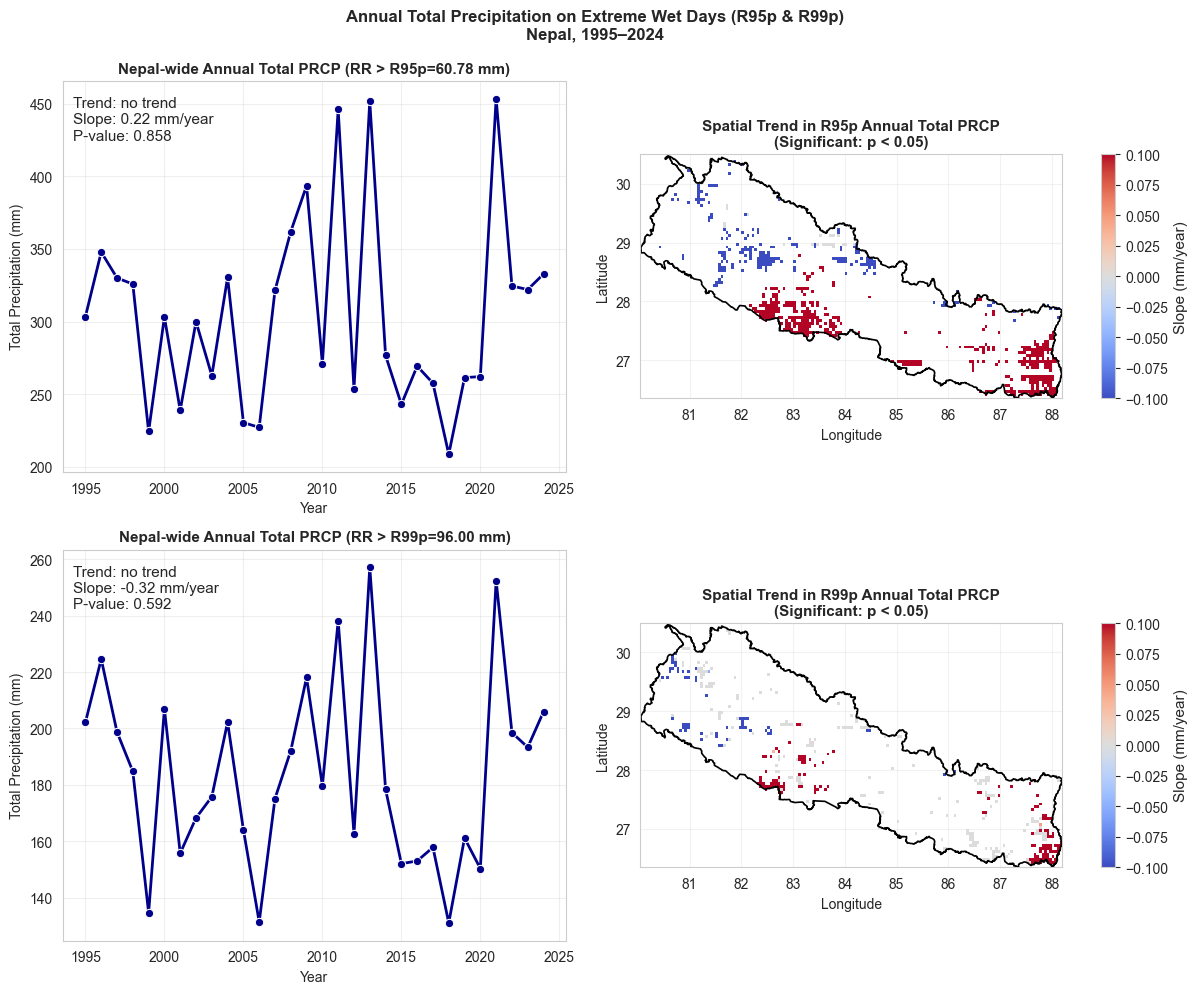

In [12]:
percentiles = [95, 99]
reference_period = dataset.sel(time=slice("1995-01-01", "2015-12-31"))  

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
ax = ax.flatten()

for i, perc in enumerate(percentiles):
    # Step 1: Calculating threshold on wet days in reference period
    ref_tp = reference_period['tp'].values.flatten()
    ref_tp = ref_tp[~np.isnan(ref_tp)]
    wet_days = ref_tp[ref_tp >= 1.0]  # only wet days
    scalar_threshold = np.percentile(wet_days, perc)

    # Step 2: Masking wet days in full dataset (RR >= 1.0 mm)
    wet_days_mask = dataset['tp'] >= 1.0
    wet_days_tp = dataset['tp'].where(wet_days_mask, other=0)

    # Step 3: Mask days exceeding threshold (RR > threshold)
    extreme_days_mask = wet_days_tp > scalar_threshold
    extreme_tp = dataset['tp'].where(extreme_days_mask, other=0)

    # Step 4: Resample annual total precipitation on extreme wet days
    annual_total_extreme_prcp = extreme_tp.resample(time='YE').sum(dim='time')

    # --- Spatial Mann-Kendall (using annual_total_extreme_prcp) ---
    lat = annual_total_extreme_prcp['lat']
    lon = annual_total_extreme_prcp['lon']
    slope_array = np.full((len(lat), len(lon)), np.nan)
    p_array = np.full((len(lat), len(lon)), np.nan)

    for j in range(len(lat)):
        for k in range(len(lon)):
            ts = annual_total_extreme_prcp[:, j, k].values
            if np.isnan(ts).all() or np.all(ts == 0):
                continue
            result = mk.original_test(ts)
            slope_array[j, k] = result.slope
            p_array[j, k] = result.p

    slope_da = xr.DataArray(slope_array, coords=[lat, lon], dims=['lat', 'lon'])
    p_da = xr.DataArray(p_array, coords=[lat, lon], dims=['lat', 'lon'])
    masked_slope_da = slope_da.where(p_da < 0.05)

    # Step 5: Calculate Nepal-wide annual mean total extreme precipitation
    # Mask zeros and negative values to NaN so they are excluded in mean calculation
    masked_prcp = annual_total_extreme_prcp.where(annual_total_extreme_prcp > 0)
    
    # Calculate mean ignoring zeros (NaNs ignored automatically)
    annual_mean = masked_prcp.mean(dim=['lat', 'lon'], skipna=True)

    df_annual = annual_mean.to_dataframe(name='mean_extreme_prcp').reset_index()
    df_annual['year'] = df_annual['time'].dt.year

    mk_result = mk.original_test(df_annual['mean_extreme_prcp'])
    slope = mk_result.slope
    p_value = mk_result.p

    # --- Plot Temporal Trend ---
    sns.lineplot(data=df_annual, x='year', y='mean_extreme_prcp', marker='o',
                 linewidth=2, ax=ax[2*i], color='darkblue')
    ax[2*i].set_title(f'Nepal-wide Annual Total PRCP (RR > R{perc}p={scalar_threshold:.2f} mm)', fontsize=11, fontweight='bold')
    ax[2*i].set_ylabel('Total Precipitation (mm)')
    ax[2*i].set_xlabel('Year')
    ax[2*i].grid(alpha=0.3)
    ax[2*i].text(0.02, 0.85,
                 f"Trend: {mk_result.trend}\nSlope: {slope:.2f} mm/year\nP-value: {p_value:.3f}",
                 transform=ax[2*i].transAxes, fontsize=11)

    # --- Plot Spatial Trend ---
    img = masked_slope_da.plot(ax=ax[2*i+1], cmap='coolwarm', vmin=-0.1, vmax=0.1, add_colorbar=False)
    divider = make_axes_locatable(ax[2*i+1])
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label('Slope (mm/year)', fontsize=11)
    gdf.boundary.plot(ax=ax[2*i+1], edgecolor='black', linewidth=1.2)
    ax[2*i+1].set_title(f'Spatial Trend in R{perc}p Annual Total PRCP\n(Significant: p < 0.05)', fontsize=11, fontweight='bold')
    ax[2*i+1].set_xlabel('Longitude')
    ax[2*i+1].set_ylabel('Latitude')
    ax[2 * i + 1].grid(True, alpha=0.25)


plt.suptitle('Annual Total Precipitation on Extreme Wet Days (R95p & R99p)\nNepal, 1995–2024',
            fontsize=12, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig("Charts/R95_99p_precip_trend.png", dpi=300)
plt.show()
plt.close()